## Imports

In [3]:
import email
import html as ihtml
import os
import pathlib
import pickle
import re
import string
import time
from collections import Counter

import autocorrect
import matplotlib.pyplot as plt
import more_itertools as mi
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import (ENGLISH_STOP_WORDS,
                                             CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from tqdm import tqdm
from tqdm.notebook import tqdm
from wordcloud import STOPWORDS, WordCloud

from progress_bar import log_progress
from text_cleaning import *

In [7]:
# nltk.download('punkt')
# nltk.download('stopwords')

## SMSSpam Dataset (not in use)

In [3]:
df = pd.read_csv("./Datasets/sms-spam-collection-dataset.csv")

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 135-136: invalid continuation byte

In [27]:
with open("./Datasets/SMSSpamCollection.txt") as f:
    data = np.array([row.split(sep="\t") for row in f.read().splitlines()])
    df = pd.DataFrame(data=data, columns=["target", "text"])
    df.target = df.target.map({"ham": 0, "spam": 1})
    del data

In [53]:
def plot_percents(g, total, fontsize=12):
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                f"{height / total * 100: .2f}%",
                ha="center", fontsize=fontsize)

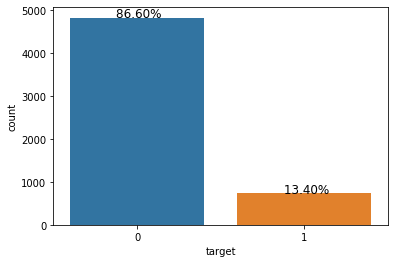

In [34]:
g = sns.countplot(df.target)
plot_percents(g, len(df.target))

In [42]:
def plot_wordcloud(text, mask=None, max_words=200, 
                   max_font_size=100, figsize=(24, 16), 
                   title=None, title_size=40):
    wordcloud = WordCloud(background_color="white", stopwords=STOPWORDS, 
                          max_words=max_words, max_font_size=max_font_size, 
                          random_state=21, width=800, height=400, mask=mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'size': title_size, 
                               'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()
    plt.show()

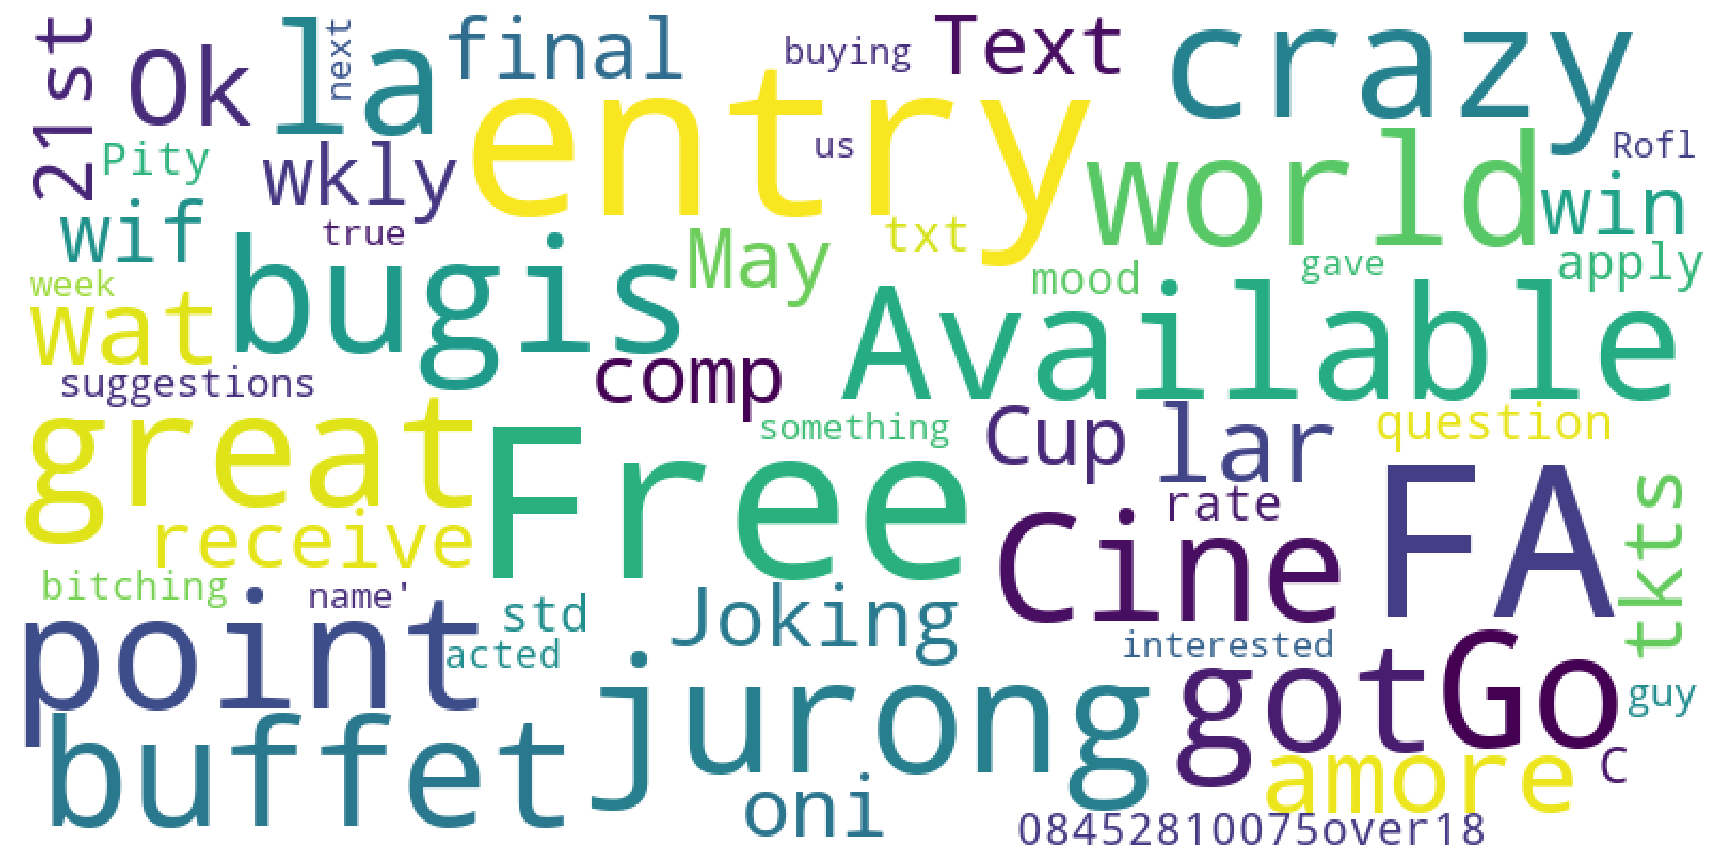

In [48]:
plot_wordcloud(df.text.values)

In [50]:
def count_ngrams(texts, n):
    frequencies = Counter()
    tokenizer = TfidfVectorizer().build_tokenizer()
    
    for text in texts:
        tokens = (token for token in tokenizer(text.lower()) if token not in STOPWORDS)
        frequencies.update(Counter(ngrams(tokens, n=n)))
        
    return frequencies

In [51]:
def plot_ngrams_frequencies(texts, n, top=10, title=None, **kwargs):
    frequencies = [(" ".join(ngram), count) for ngram, count in count_ngrams(texts, n).most_common(top)]
    frequencies = pd.DataFrame(frequencies, columns=["words", "count"])
    
    sns.barplot(x="count", y="words", data=frequencies, **kwargs)
    
    ax = kwargs.get("ax", plt.gca())
    
    if title is not None:
        ax.set_title(title)
    ax.grid(True, axis="x", alpha=.3)
        
    sns.despine(left=True, bottom=True)

In [58]:
def plot_ngrams_frequencies_by_target(df, column, n, top=10, suptitle=None, 
                                      titles=["Ham", "Spam"], 
                                      colors=["tab:blue", "tab:red"], figsize=(10, 7)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    
    plot_ngrams_frequencies(df[df.target == 0][column], n, top, titles[0], color=colors[0], ax=ax[0])
    plot_ngrams_frequencies(df[df.target == 1][column], n, top, titles[1], color=colors[1], ax=ax[1])
    
    plt.suptitle(suptitle, y=1.05)
    fig.tight_layout()
    plt.show()

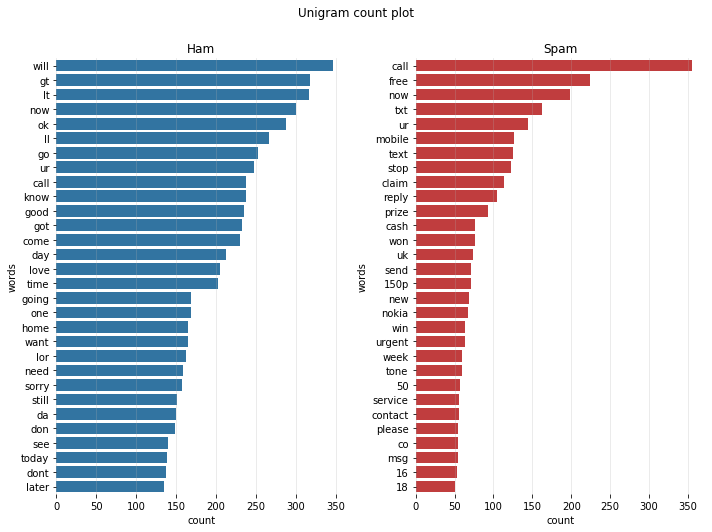

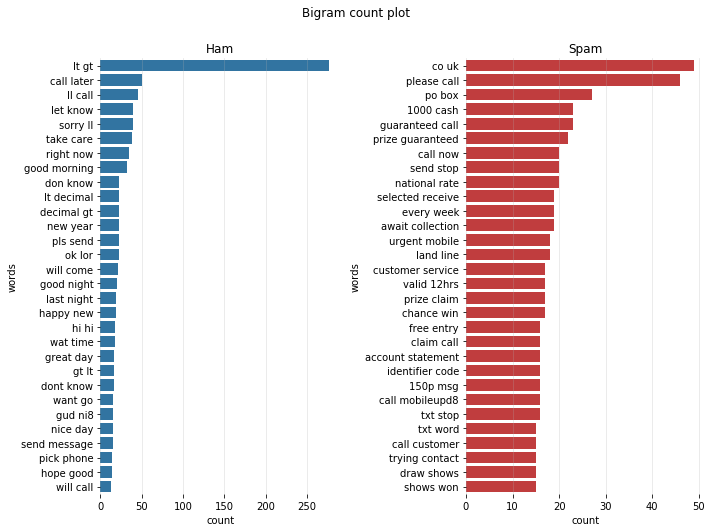

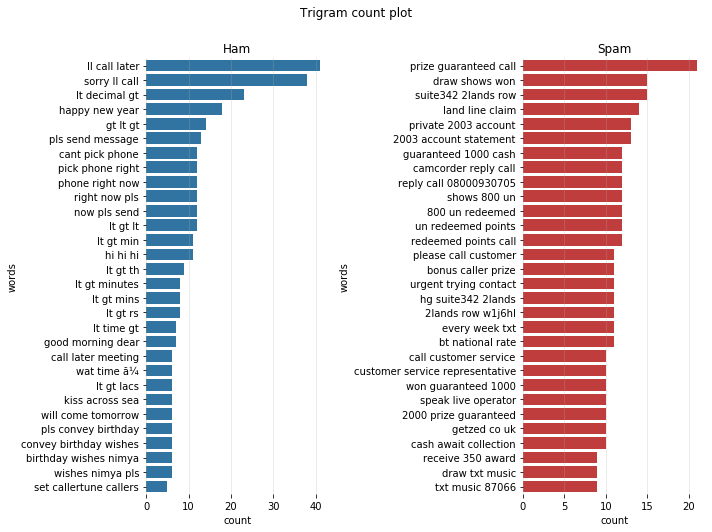

In [63]:
top_n = 30
titles = ("Unigram count plot", "Bigram count plot", "Trigram count plot")

[plot_ngrams_frequencies_by_target(df, "text", n, top_n, title) for n, title in zip(range(1, 4), titles)];

## TREC Dataset

In [4]:
print("–" in string.punctuation)
print("—" in string.punctuation)
PUNCTUATIONS = set(string.punctuation)
PUNCTUATIONS.add("–")
PUNCTUATIONS.add("—")
print(PUNCTUATIONS)

False
False
{'–', '#', '*', '}', "'", '`', '<', '!', '>', '~', '=', '\\', '&', '"', '%', '|', '(', '+', '^', ')', '-', '[', ';', '?', ']', '/', '_', ',', '$', '.', '{', '—', ':', '@'}


In [5]:
DATASET_DIR = pathlib.Path("Datasets/trec07p/data")
LABELS_PATH = pathlib.Path("Datasets/trec07p/full/index")

In [6]:
labels = dict()

with open(LABELS_PATH, "r") as f:
    for line in f:
        line = line.strip()
        label, key = line.split()
        file_name = key.split("/")[-1]
        labels[file_name] = label

In [7]:
file_list = os.listdir(DATASET_DIR)

In [8]:
file_list[:5]

['inmail.1', 'inmail.10', 'inmail.100', 'inmail.1000', 'inmail.10000']

### Email (Message) structure

In [9]:
msg = []

for i in range(10):
    with open(pathlib.Path(DATASET_DIR, file_list[i])) as f:
        msg.append(email.message_from_file(f))

In [10]:
for key, value in msg[0].items():
    print(key, ": ", value)

Return-Path :  <RickyAmes@aol.com>
Received :  from 129.97.78.23 ([211.202.101.74])
	by speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;
	Sun, 8 Apr 2007 13:07:21 -0400
Received :  from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100
Message-ID :  <WYADCKPDFWWTWTXNFVUE@yahoo.com>
From :  "Tomas Jacobs" <RickyAmes@aol.com>
Reply-To :  "Tomas Jacobs" <RickyAmes@aol.com>
To :  the00@speedy.uwaterloo.ca
Subject :  Generic Cialis, branded quality@ 
Date :  Sun, 08 Apr 2007 21:00:48 +0300
X-Mailer :  Microsoft Outlook Express 6.00.2600.0000
MIME-Version :  1.0
Content-Type :  multipart/alternative;
	boundary="--8896484051606557286"
X-Priority :  3
X-MSMail-Priority :  Normal
Status :  RO
Content-Length :  988
Lines :  24


In [11]:
print(msg[0].keys())

['Return-Path', 'Received', 'Received', 'Message-ID', 'From', 'Reply-To', 'To', 'Subject', 'Date', 'X-Mailer', 'MIME-Version', 'Content-Type', 'X-Priority', 'X-MSMail-Priority', 'Status', 'Content-Length', 'Lines']


In [12]:
# [print("print(msg[\"" + key + "\"])") for key in msg.keys()];

In [13]:
# print(msg[0]["Return-Path"])
# print(msg[0]["Received"])
# print(msg[0]["Received"])
# print(msg[0]["Message-ID"])
# print(msg[0]["From"])
# print(msg[0]["Reply-To"])
# print(msg[0]["To"])
# print(msg[0]["Subject"])
# print(msg[0]["Date"])
# print(msg[0]["X-Mailer"])
# print(msg[0]["MIME-Version"])
# print(msg[0]["Content-Type"])
# print(msg[0]["X-Priority"])
# print(msg[0]["X-MSMail-Priority"])
# print(msg[0]["Status"])
# print(msg[0]["Content-Length"])
# print(msg[0]["Lines"])

Extracting message's body:

https://www.kaggle.com/ceshine/remove-html-tags-using-beautifulsoup

In [14]:
# print(msg[0].get_payload()[0].get_payload())
print(clean_text(msg[0].get_payload()[0].get_payload()))

 do you feel the pressure to perform and not rising to the occasion try viagra your anxiety will be a thing of the past and you will be back to your old self 


Let's write functions to obtain message's body:

In [15]:
def extract_message_atomic_parts(msg):
    return [[part.get_content_type(), part.get_payload()] 
            for part in msg.walk() if not part.is_multipart()]

In [16]:
emap = extract_message_atomic_parts(msg[2])
emap

[['text/plain', ''],
 ['text/html',
  '<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n<HTML><HEAD>\n<META http-equiv=3DContent-Type content=3D"text/html; charset=3Dkoi8-r">\n<META content=3D"MSHTML 6.00.2900.2180" name=3DGENERATOR>\n<STYLE></STYLE>\n</HEAD>\n<BODY bgColor=3D#ffffff>\n<DIV><A href=3D"http://tvqsgg.ozkk.hk/?73260120"><IMG alt=3D"" hspace=3D0=20\nsrc=3D"cid:000301c634d3$5e87f4f0$aa0fa8c0@sanya" align=3Dbaseline=20\nborder=3D0></A></DIV></BODY></HTML>\n'],
 ['image/jpeg',
  '/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0a\nHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIy\nMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAD2AbsDASIA\nAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQA\nAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3\nODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWm\np6ipqrKztLW2t7i5usLDxM

In [17]:
def _is_plain(x):
    return "plain" in x[0]


def _is_html(x):
    return "html" in x[0]


def handle_emap(emap):
#     plain = next(filter(lambda x: "plain" in x[0], emap), None)
    plain = mi.first_true(emap, default=None, pred=_is_plain)
    if plain is not None:
        return plain[-1]
    
#     html = next(filter(lambda x: "html" in x[0], emap), None)
    html = mi.first_true(emap, default=None, pred=_is_html)
    if html is not None:
        return html[-1]
    
    if len(emap) == 1:
        return emap[0][1]
    else:
        raise ValueError(f"Can't handle email message atomic parts.")

In [18]:
handle_emap(emap)

''

In [19]:
def extract_message_text(msg):
    emap = extract_message_atomic_parts(msg)
    return handle_emap(emap)

In [20]:
msg[1].get_payload()

'\nHi...\n\nI have to use R to find out the 90% confidence-interval for the sensitivity\nand specificity of the following diagnostic test:\n\nA particular diagnostic test for multiple sclerosis was conducted on 20 MS\npatients and 20 healthy subjects, 6 MS patients were classified as healthy\nand 8 healthy subjects were classified as suffering from the MS.\n\nFurthermore, I need to find the number of MS patients required for a\nsensitivity of 1%...\n\nIs there a simple R-command which can do that for me?\n\nI am completely new to R...\n\nHelp please!\n\nJochen\n-- \nView this message in context: http://www.nabble.com/Confidence-Intervals....-help...-tf3544217.html#a9894014\nSent from the R help mailing list archive at Nabble.com.\n\n______________________________________________\nR-help@stat.math.ethz.ch mailing list\nhttps://stat.ethz.ch/mailman/listinfo/r-help\nPLEASE do read the posting guide http://www.R-project.org/posting-guide.html\nand provide commented, minimal, self-contained

In [21]:
print(clean_text(extract_message_text(msg[1])), end="\n\n")
# print(autocorrect.Speller().autocorrect_sentence(sentence=clean_text(extract_message_text(msg[1]))))

hi i have to use r to find out the 90 confidence interval for the sensitivity and specificity of the following diagnostic test a particular diagnostic test for multiple sclerosis was conducted on 20 ms patients and 20 healthy subjects 6 ms patients were classified as healthy and 8 healthy subjects were classified as suffering from the ms furthermore i need to find the number of ms patients required for a sensitivity of 1 is there a simple r command which can do that for me i am completely new to r help please jochen view this message in context sent from the r help mailing list archive at nabble com r help stat math ethz ch mailing list please do read the posting guide and provide commented minimal self contained reproducible code 



### Misspellings fixes

In [28]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

In [ ]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

In [240]:
# lookup suggestions for single-word input strings
input_term = "memebers"  # misspelling of "members"
# max edit distance per lookup
# (max_edit_distance_lookup <= max_dictionary_edit_distance)
suggestions = sym_spell.lookup(input_term, Verbosity.CLOSEST,
                               max_edit_distance=2, include_unknown=True)
# display suggestion term, term frequency, and edit distance
for suggestion in suggestions:
    print(suggestion)

members, 1, 453312306


In [244]:
suggestions[0].term

'members'

In [234]:
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [235]:
# lookup suggestions for multi-word input strings (supports compound
# splitting & merging)
input_term = ("whereis th elove hehad dated forImuch of thepast who "
              "couqdn'tread in sixtgrade and ins pired him")
# max edit distance per lookup (per single word, not per whole input string)
suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
# display suggestion term, edit distance, and term frequency
for suggestion in suggestions:
    print(suggestion)

where is the love he had dated for much of the past who couldn't read in six grade and inspired him, 9, 0


### Looking at messages content types

In [22]:
ATTRIBUTES = {
    'Return-Path',
    'Received',
    'Received',
    'Message-ID',
    'From',
    'Reply-To',
    'To',
    'Subject',
    'Date',
    'X-Mailer',
    'MIME-Version',
    'Content-Type',
    'X-Priority',
    'X-MSMail-Priority',
    'Status',
    'Content-Length',
    'Lines'
}

In [23]:
def collect_content_types(msg):
    return [part.get_content_type() for part in msg.walk()]

In [24]:
def extract_file_info(path, reader, handler):
    with open(path, errors="ignore") as f:
        msg = reader(f)
        
    if not msg:
        raise ValueError(f"Can't read file using {reader}.")
        
    return handler(msg)

In [25]:
def extract_email_content_type(path):
    return extract_file_info(path, email.message_from_file, collect_content_types)

In [26]:
def handle_email_message(msg):
    info = dict.fromkeys(ATTRIBUTES, None)
    
    for attr in ATTRIBUTES:
        info[attr] = msg[attr]
        
    info["Body"] = clean_text(extract_message_text(msg))
    
    return info

In [27]:
def extract_email_info(path):
    return extract_file_info(path, email.message_from_file, handle_email_message)

In [28]:
extract_email_info(pathlib.Path(DATASET_DIR, file_list[0]))

{'Content-Type': 'multipart/alternative;\n\tboundary="--8896484051606557286"',
 'Reply-To': '"Tomas Jacobs" <RickyAmes@aol.com>',
 'Message-ID': '<WYADCKPDFWWTWTXNFVUE@yahoo.com>',
 'Return-Path': '<RickyAmes@aol.com>',
 'X-Priority': '3',
 'Subject': 'Generic Cialis, branded quality@ ',
 'Content-Length': '988',
 'MIME-Version': '1.0',
 'Lines': '24',
 'Date': 'Sun, 08 Apr 2007 21:00:48 +0300',
 'X-Mailer': 'Microsoft Outlook Express 6.00.2600.0000',
 'To': 'the00@speedy.uwaterloo.ca',
 'From': '"Tomas Jacobs" <RickyAmes@aol.com>',
 'X-MSMail-Priority': 'Normal',
 'Status': 'RO',
 'Received': 'from 129.97.78.23 ([211.202.101.74])\n\tby speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;\n\tSun, 8 Apr 2007 13:07:21 -0400',
 'Body': ' do you feel the pressure to perform and not rising to the occasion try viagra your anxiety will be a thing of the past and you will be back to your old self '}

### Looking at messages content types

In [36]:
ct = [extract_email_content_type(pathlib.Path(DATASET_DIR, file_name)) 
      for file_name in tqdm(file_list)]

KeyboardInterrupt: 

In [327]:
ct[-3:]

[['text/html'],
 ['text/plain'],
 ['multipart/alternative', 'text/plain', 'text/html']]

In [329]:
np.where(["text/plain" not in x and "text/html" not in x for x in ct])

(array([38561, 41231, 54742, 71328], dtype=int64),)

In [331]:
for i in [38561, 41231, 54742, 71328]:
    with open(pathlib.Path(DATASET_DIR, file_list[i])) as f:
        tmp = email.message_from_file(f)
        print(tmp.get_content_type(), tmp.is_multipart(), sep="\n", end="\n\n")

multipart/alternative
False

multipart/alternative
False

multipart/alternreturn-path: <accounting@aaawnca.com>
False

text/
False



In [322]:
with open(pathlib.Path(DATASET_DIR, file_list[71328])) as f:
    tmp = email.message_from_file(f)

In [338]:
print("HTML only + Incorrect: ", sum("text/plain" not in x for x in ct))
print("Incorrect: ", sum("text/plain" not in x and "text/html" not in x for x in ct))

HTML only + Incorrect:  16946
Incorrect:  4


### Forming DataFrame

In [29]:
email_info = [extract_email_info(pathlib.Path(DATASET_DIR, file_name)) 
              for file_name in tqdm(file_list)]

C:\Users\vladm\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://yenibiris.sendeyolla.com/medyadetay.aspx?&tid=3&cid=57&id=61365



" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\vladm\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://agsydhfj.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\vladm\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://owfajfqruture.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

In [40]:
y_target_iterator = (1 if labels[file_name] == "spam" else 0 for file_name in file_list)
y_target = np.fromiter(y_target_iterator, dtype=np.uint8, count=len(file_list))

In [42]:
df = pd.DataFrame(email_info)
df["target"] = y_target

In [43]:
df.to_csv("Datasets/trec07p/trec.csv", index=False)

In [436]:
df = pd.read_csv("Datasets/trec07p/trec.csv", index_col=False)

In [51]:
df.head()

,Content-Type,Reply-To,Message-ID,Return-Path,X-Priority,Subject,Content-Length,MIME-Version,Lines,Date,X-Mailer,To,From,X-MSMail-Priority,Status,Received,Body,target
0,"multipart/alternative;\n\tboundary=""--88964840...","""Tomas Jacobs"" <RickyAmes@aol.com>",<WYADCKPDFWWTWTXNFVUE@yahoo.com>,<RickyAmes@aol.com>,3,"Generic Cialis, branded quality@",988.0,1.0,24.0,"Sun, 08 Apr 2007 21:00:48 +0300",Microsoft Outlook Express 6.00.2600.0000,the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>",Normal,RO,from 129.97.78.23 ([211.202.101.74])\n\tby spe...,do you feel the pressure to perform and not r...,1
1,"text/plain; charset=""us-ascii""",NaN,<9894014.post@talk.nabble.com>,<r-help-bounces@stat.math.ethz.ch>,NaN,[R] Confidence-Intervals.... help...,992.0,1.0,29.0,"Sun, 8 Apr 2007 10:19:39 -0700 (PDT)",NaN,r-help@stat.math.ethz.ch,"""Jochen.F"" <jjfahr@ucalgary.ca>",NaN,O,from hypatia.math.ethz.ch (hypatia.math.ethz.c...,hi i have to use r to find out the 90 confiden...,0
2,"multipart/related;\n\ttype=""multipart/alternat...",NaN,<000001c77a19$b4d55780$0100007f@malhotra-axpwjx>,<robert@scandinavian-seed.biz>,3,She wants a better sex? All you need's here!,25368.0,1.0,356.0,"Sun, 08 Apr 2007 21:08:43 +0100",Microsoft Outlook Express 6.00.2900.2180,<manager@speedy.uwaterloo.ca>,"""Rogert"" <robert@scandinavian-seed.biz>",Normal,O,from friend (82-44-240-212.cable.ubr01.haye.bl...,NaN,1
3,"multipart/alternative; boundary=""011gktorp011""",NaN,<200704091834.l39IYQ0I018124@speedy.uwaterloo.ca>,<owner-LARRYKING*ktwarwic**SPEEDY*-UWATERLOO*-...,NaN,Could Immortality Become a Reality?,5031.0,1.0,185.0,"Mon, 9 Apr 2007 14:31:03 -0400",NaN,ktwarwic@SPEEDY.UWATERLOO.CA,Larry King Live <larryking@mail.cnn.com>,NaN,O,from cnnimail22.cnn.com (cnnimail22.cnn.com [6...,larry king live at 9 00 p m et on monday april...,0
4,"multipart/related;\n\tboundary=""----=_NextPart...",NaN,<000001c77ffc$ae884200$0100007f@localhost>,<spitfireaviation.com@lotto-otto.com>,3 (Normal),Play over 50 lotteries online,22021.0,1.0,327.0,"Mon, 16 Apr 2007 15:56:05 +0800","Microsoft Outlook, Build 10.0.2900",<gnitpick@speedy.uwaterloo.ca>,"""Jaiden Collins"" <spitfireaviation.com@lotto-o...",Normal,O,from localhost ([220.234.26.96])\n\tby speedy....,lotteryagent tm is the only online service tha...,1


In [181]:
# with open("ALL_ATTRIBUTES.bin", "wb") as f:
#     pickle.dump(ALL_ATTRIBUTES, f)

In [27]:
with open("ALL_ATTRIBUTES.bin", "rb") as f:
    ALL_ATTRIBUTES = pickle.load(f)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 18 columns):
Content-Type         73329 non-null object
Reply-To             19408 non-null object
X-MSMail-Priority    18629 non-null object
Lines                26800 non-null object
To                   74865 non-null object
Subject              75419 non-null object
Date                 75394 non-null object
Received             75419 non-null object
Message-ID           75419 non-null object
Status               26269 non-null object
Content-Length       26150 non-null object
Return-Path          75419 non-null object
From                 75419 non-null object
MIME-Version         75419 non-null object
X-Priority           27153 non-null object
X-Mailer             75419 non-null object
Body                 75419 non-null object
target               75419 non-null int32
dtypes: int32(1), object(17)
memory usage: 10.1+ MB


In [43]:
df.describe(include=["object"])

,Content-Type,Reply-To,X-MSMail-Priority,Lines,To,Subject,Date,Received,Message-ID,Status,Content-Length,Return-Path,From,MIME-Version,X-Priority,X-Mailer,Body
count,73329,19408,18629,26800,74865,75419,75394,75419,75419,26269,26150,75419,75419,75419,27153,75419,75419
unique,31567,5824,7,862,9341,33673,70712,75419,74599,13,8006,45211,47219,32,13,1133,54272
top,"text/plain; charset=""us-ascii""",,Normal,104,samba-cvs@samba.org,Avis Important et Personnel,"Wed, 27 Jun 2007 12:48:17 -0700",from lists.develooper.com (x6.develooper.com [...,<3PT84D62EK02TDBZ@DN730O3U5203CY553P49T1>,O,5798,<r-help-bounces@stat.math.ethz.ch>,Groupe Desjardins / AccesD <services.de.cartes...,1.0,3,Empty,
freq,8024,3206,18416,2564,2396,2974,24,1,43,25720,2524,6637,2826,66498,17914,33615,2780


In [44]:
df.isna().sum()

Content-Type          2090
Reply-To             56011
X-MSMail-Priority    56790
Lines                48619
To                     554
Subject                  0
Date                    25
Received                 0
Message-ID               0
Status               49150
Content-Length       49269
Return-Path              0
From                     0
MIME-Version             0
X-Priority           48266
X-Mailer                 0
Body                     0
target                   0
dtype: int64

### Looking at variables distributions

In [359]:
def identity(x):
    return x


def swap_coords(position):
    return position[::-1]


import matplotlib as mpl

AXES_CLASS = mpl.axes.Axes
BAR_CLASS = mpl.patches.Rectangle

VERTICAL_BAR_TOOLS = {
    "get_lim": AXES_CLASS.get_ylim, 
    "set_lim": AXES_CLASS.set_ylim, 
    "lim_modifier": 1.05, 
    "percent_height_modifier": 1.005,
    "get_bar_coord": BAR_CLASS.get_x,
    "get_bar_height": BAR_CLASS.get_height,
    "get_bar_width": BAR_CLASS.get_width,
    "position_handler": identity
}

HORIZONTAL_BAR_TOOLS = {
    "get_lim": AXES_CLASS.get_xlim, 
    "set_lim": AXES_CLASS.set_xlim, 
    "lim_modifier": 1.1, 
    "percent_height_modifier": 1.07,
    "get_bar_coord": BAR_CLASS.get_y,
    "get_bar_height": BAR_CLASS.get_width,
    "get_bar_width": BAR_CLASS.get_height,
    "position_handler": swap_coords
}

In [364]:
def plot_bar_percent(patch, total, orientation, tools, fontsize):
    percent_height_modifier = tools["percent_height_modifier"]
    bar_coord = tools["get_bar_coord"](patch)
    bar_height = tools["get_bar_height"](patch)
    bar_width = tools["get_bar_width"](patch)
    
    x = bar_coord + bar_width / 2.
    y = percent_height_modifier * bar_height
    
    x, y = tools["position_handler"]((x, y))
    s = f"{bar_height / total * 100: .2f}%"
    
    return g.text(x, y, s, ha="center", fontsize=fontsize)

In [369]:
def plot_percents(g, orientation="v", fontsize=12):
    tools = tools = VERTICAL_BAR_TOOLS if orientation.startswith("v") else HORIZONTAL_BAR_TOOLS
    
    min_, max_ = tools["get_lim"](g)
    lim_modifier = tools["lim_modifier"]
    tools["set_lim"](g, min_, lim_modifier * max_)
    
    get_bar_height = tools["get_bar_height"]
    total = sum(get_bar_height(patch) for patch in g.patches if isinstance(patch, BAR_CLASS))
    
    for patch in g.patches:
        if isinstance(patch, BAR_CLASS):
            plot_bar_percent(patch, total, orientation, tools, fontsize)
            
    return g

In [430]:
def plot_distributions(df, column, orient=None, xticks_rotation=None):
    tmp = pd.crosstab(df[column], df["target"], normalize="index") * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: "Ham", 1: "Spam"}, inplace=True)

    plt.figure(figsize=(14, 10))
    plt.suptitle(f"{column} Distributions", fontsize=22)

    plt.subplot(2, 2, 1)
    order = df[column].value_counts().index
    
    if len(order) <= 7 if orient is None else orient.startswith("v"): 
        orient = {"x": column, "orient": "v"}
        add_spam = lambda orient: orient.__setitem__("y", "Spam")
    else:
        orient = {"y": column, "orient": "h"}
        add_spam = lambda orient: orient.__setitem__("x", "Spam")
        
    g = sns.countplot(**orient, data=df, order=order)

    g.set_title(f"{column} Distribution", fontsize=19)
    g.set_xlabel(f"{column} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(), rotation=xticks_rotation)

    total = df.shape[0]
    plot_percents(g, orient["orient"], fontsize=9)

    plt.subplot(2, 2, 2)
    g1 = sns.countplot(x=column, hue="target", data=df, order=order)

    plt.legend(title="Spam", loc="best", labels=["False", "True"],
               bbox_to_anchor=(1., 1.25), bbox_transform=g1.transAxes)

    gt = g1.twinx()
    
    dtype = type(df[column][0])
    add_spam(orient)
    
    # TODO: change orient
    gt = sns.pointplot(x=column, y="Spam", data=tmp, color="black", scale=.7, 
                       order=order, legend=False)
    gt.set_ylabel("% of Spam emails", fontsize=16)

    g1.set_title(f"{column} by target", fontsize=19)
    g1.set_xlabel(f"{column} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)
    g1.set_xticklabels(g1.get_xticklabels(), rotation=xticks_rotation)

    plt.subplots_adjust(hspace=0.6, top=0.85)

    plt.show()

In [372]:
def plot_continuous_distribution(df, column):
    plt.figure(figsize=(16, 12))
    plt.suptitle(f"{column} Values Distribution", fontsize=22)

    plt.subplot(2, 2, 1)
    g = sns.distplot(df[column])    # between??
    g.set_title(f"{column} Distribution", fontsize=18)
    g.set_xlabel("")
    g.set_ylabel("Probability", fontsize=15)

    plt.subplot(2, 2, 2)
    g1 = sns.distplot(np.log(df[column], where=df[column] != 0))
    g1.set_title(f"{column} (Log) Distribuition", fontsize=18)
    g1.set_xlabel("")
    g1.set_ylabel("Probability", fontsize=15)

    plt.figure(figsize=(16, 12))


    plt.subplot(2, 1, 2)
    g4 = plt.scatter(range((df["target"] == 0).sum()),
                     np.sort(df[df["target"] == 0][column]), 
                     label="Ham", alpha=.2)
    g4 = plt.scatter(range((df["target"] == 1).sum()),
                     np.sort(df[df["target"] == 1][column]), 
                     label="Spam", alpha=.2)
    g4= plt.title(f"ECDF \nSPAM and HAM {column} Distribution", fontsize=18)
    g4 = plt.xlabel("Index", fontsize=15)
    g4 = plt.ylabel(f"{column} Distribution", fontsize=15)
    g4 = plt.legend()

    plt.figure(figsize=(16,12))

    plt.subplot(3, 2, 1)
    prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    g = plt.scatter(range((df["target"] == 1).sum()),
                    np.sort(df[df["target"] == 1][column]), 
                    label="Spam", alpha=.4, color=prop_cycle[1])
    plt.title(f"SPAM - {column} ECDF", fontsize=18)
    plt.xlabel("Index", fontsize=15)
    plt.ylabel(f"{column} Distribution", fontsize=15)

    plt.subplot(322)
    g1 = plt.scatter(range((df["target"] == 0).sum()),
                     np.sort(df[df["target"] == 0][column]), 
                     label="Ham", alpha=.2)
    g1= plt.title(f"HAM - {column} ECDF", fontsize=18)
    g1 = plt.xlabel("Index", fontsize=15)
    g1 = plt.ylabel(f"{column} Distribution", fontsize=15)

    plt.suptitle('Individual ECDF Distribution', fontsize=22)

    plt.show()

#### Target Distribution

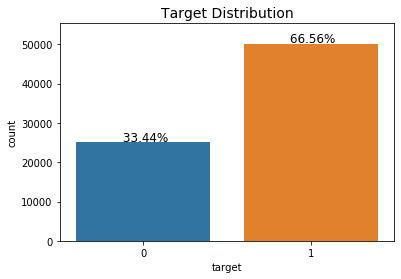

In [468]:
g = sns.countplot(x="target", data=df)
plot_percents(g)
plt.title("Target Distribution", fontdict={"size": 14})
plt.show()

#### Lines Distribution

In [464]:
df["Lines"] = df["Lines"].astype(int, errors="ignore")

lines = df[["Lines", "target"]].dropna()
lines["Lines"] = lines["Lines"].astype(int)

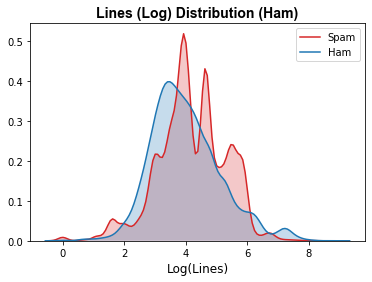

In [467]:
for target, color in zip(df["target"].unique(), ("tab:red", "tab:blue")):
    sns.kdeplot(np.log(lines[lines["target"] == target]["Lines"], 
                       where=lines[lines["target"] == target]["Lines"] != 0), 
                color=color, shade=True)
    
plt.title("Lines (Log) Distribution (Ham)", 
            fontdict={
                "fontfamily": "arial", 
                "fontsize": 14, 
                "fontweight": "bold"
            })
plt.xlabel("Log(Lines)", fontdict={"size": 12})
plt.legend(["Spam", "Ham"])
plt.show()

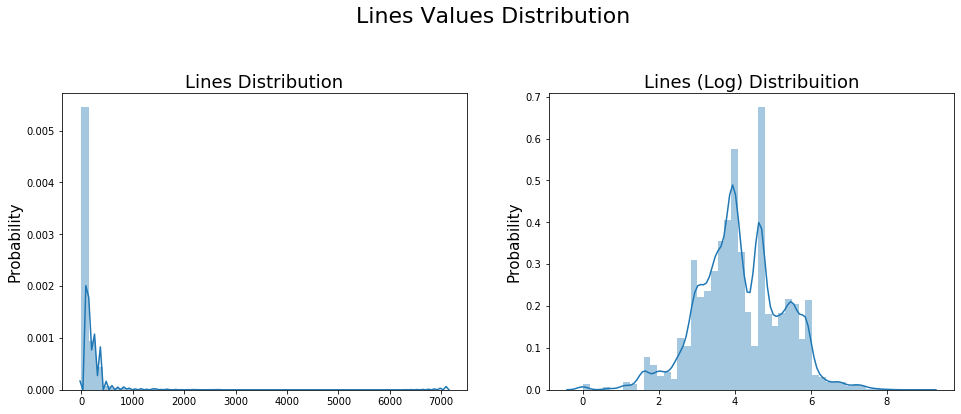

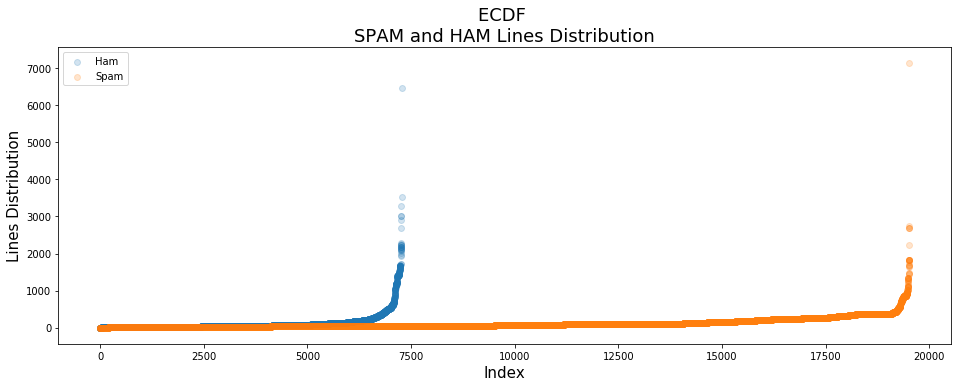

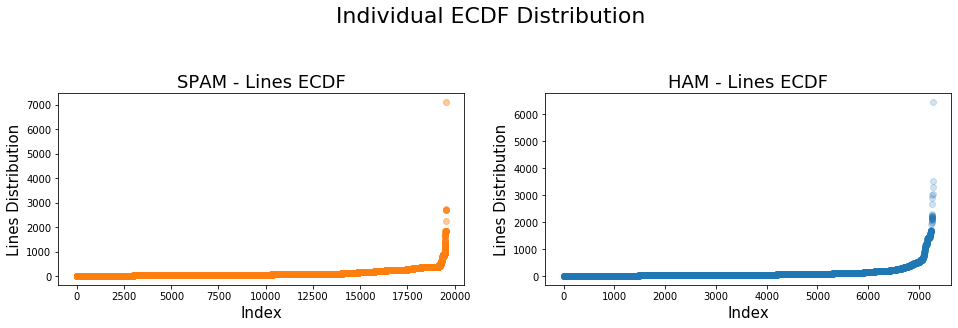

In [61]:
plot_continuous_distribution(lines, "Lines")

#### Content-Length Distribution

In [62]:
df["Content-Length"] = df["Content-Length"].astype(int, errors="ignore")

content_length = df[["Content-Length", "target"]].dropna()
content_length["Content-Length"] = content_length["Content-Length"].astype(int)

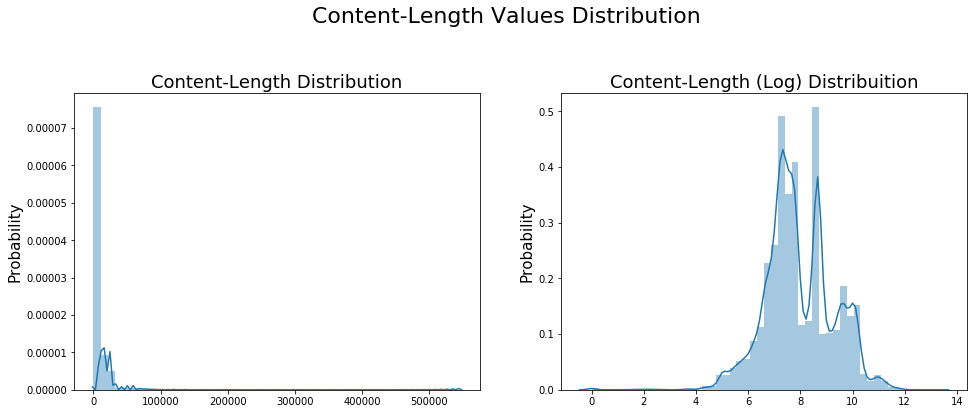

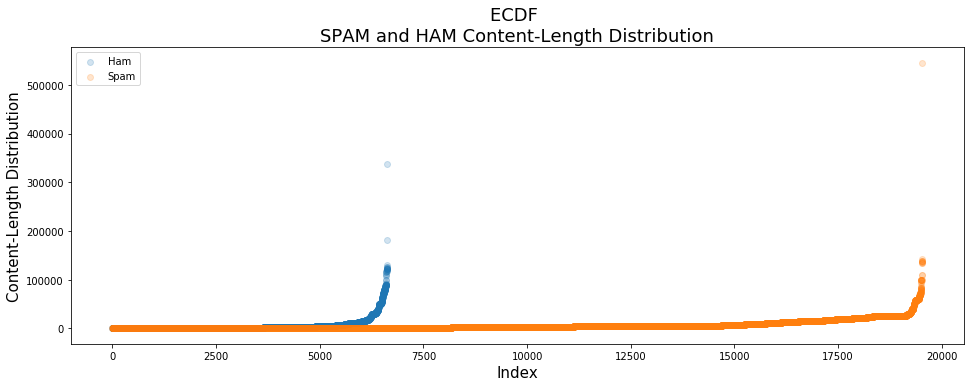

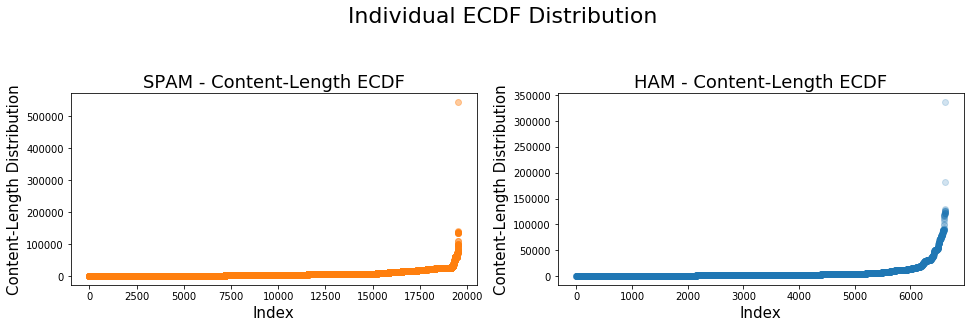

In [448]:
plot_continuous_distribution(content_length, "Content-Length")

#### MIME-Version Distribution

In [443]:
df["MIME-Version"] = df["MIME-Version"].fillna("Empty")

In [426]:
df.groupby(["MIME-Version", "target"])[["Body"]].agg(len)

Body
MIME-Version                               target       
1.0                                        0       20916
                                           1       45152
1.0                                        0           5
                                           1         619
1.0                                        0           1
1.0 (Apple Message framework v624)         0         139
1.0 (Apple Message framework v728)         0           1
1.0 (Apple Message framework v752.2)       0         312
1.0 (Apple Message framework v752.3)       0         397
1.0 (Apple Message framework v880)         0          24
1.0 (Apple Message framework v884)         0           5
1.0 (Apple Message framework v885)         0           8
1.0 (Apple Message framework v886.1)       0           6
1.0 (Apple Message framework v890.1)       0          16
1.0 (Apple Message framework v890.2)       0          27
1.0 (Apple Message framework v893)         0           5
1.0 (generated by SEMI 1.14.6 - "Maruoka") 0          10
1.0 (iPhone Mail 1A543a)                   0           1
1.0 (produced by  .)                       1           3
1.0 (produced by  0.0)                     1           1
1.0 (produced by  0.5)                     1           1
1.0 (produced by  1.3)                     1           1
1.0 (produced by  3.9)                     1           2
1.0 (produced by  4.3)                     1           1
1.0 (produced by  7.5)                     1           1
2.1 (original: E. Nishida-574729927434     1           1
2.1 (original: R. Greaney-254725192)       1           1
2.2 (original: O. Elsea-27520643609776     1           1
2.3 (original: D. Eno-450868851284         1           1
2.4 (original: A. Summerall-0829800680)    1           1
2.4 (original: Y. Laguerre-08820827865     1           1
2.9 (original: F. Garbutt-7748321322504)   1           1
2.9 (original: T. Cracraft-4541350777550)  1           1
Empty                                      0        3266
                                           1        4013
Other                                      Other     478

In [444]:
def handle_mime(mime):
    if "apple" in mime.lower() or "iphone" in mime.lower():
        return "1.0 (Apple)"
    elif "1.0" in mime.strip():
        return "1.0"
    elif mime.lower() == "empty":
        return mime
    else:
        return "Other"

In [445]:
df["MIME-Version"] = df["MIME-Version"].map(handle_mime)

In [446]:
df.groupby(["MIME-Version", "target"])[["Body"]].agg(len)

Body
MIME-Version target       
1.0          0       20991
             1       46154
1.0 (Apple)  0         945
Empty        0        3284
             1        4037
Other        1           8

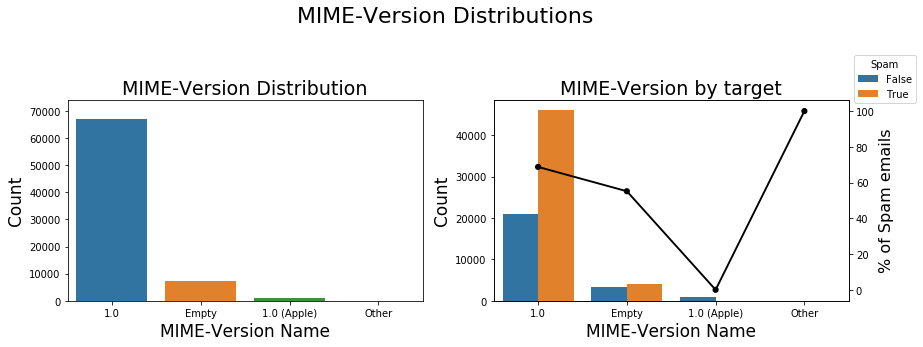

In [447]:
plot_distributions(df, "MIME-Version")

#### X-Priority Distribution

In [440]:
def handle_xpriority(x):
    if x is np.nan or x is None:
        return -1
    elif isinstance(x, float):
        return int(x)
    else:
        try:
            return int(x.split()[0])
        except ValueError:
            return -1

In [441]:
df["X-Priority"] = df["X-Priority"].map(handle_xpriority)

In [89]:
df.groupby(["X-Priority", "target"])[["Body"]].agg(len)

Body
X-Priority target       
-1         0       24008
           1       24286
 0         1           4
 1         0          12
           1         642
 2         1         328
 3         0        1200
           1       24929
 4         1           8
 5         1           2

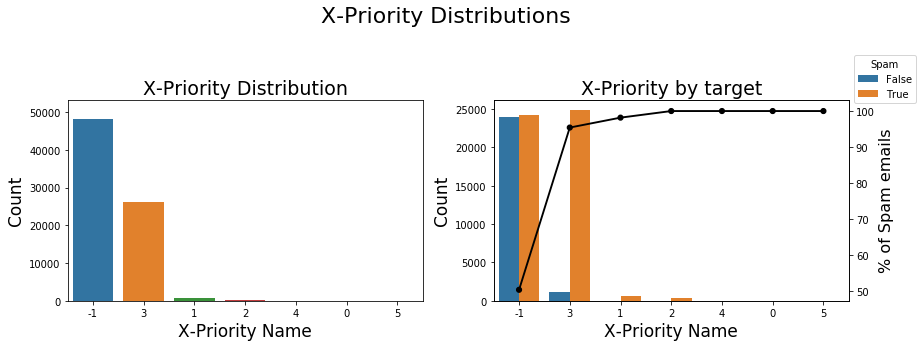

In [442]:
plot_distributions(df, "X-Priority")

#### X-Mailers Distribution

In [203]:
df.loc[df["X-Mailer"].isna(), "X-Mailer"] = "Empty"

In [204]:
# TODO: add mailers
MAILERS = {
    "%WORD", "AIM WebMail", "AOL", "Apple Mail", "AtMail", "BBC",
    "Becky!", "Claws Mail", "CommuniGate Pro", "EMUmail", 
    "Endymion MailMan", "Evolution", "FoxMail", "GOOD Mailer", "IncrediMail", 
    "Internet Mail Service", "Lotus", "MIME", "Mediacomm Communicator", 
    "Mew", "Microsoft", "Mirapoint Webmail", "Mozilla", "Mulberry", 
    "Mutt", "Novell GroupWise", "Openwave WebEngine", "PMMail", 
    "Pegasus Mail", "Prayer", "QUALCOMM", "SquirrelMail", "StrongMail", "Sun", 
    "Sylpheed", "TWIG", "The Bat!", "VM", "VolleyMail", "WWW-Mail", 
    "Ximian", "Yahoo", "devMail.Net", "dtmail", "iPlanet"
}

In [205]:
def handle_xmailer(x):
    if not x:
        return "Empty"

    for mailer in MAILERS:
        if x.startswith(mailer):
            return mailer
    
    return x

In [206]:
df["X-Mailer"] = df["X-Mailer"].map(handle_xmailer)

In [207]:
pd.set_option("max_rows", None)

In [104]:
df.groupby(["X-Mailer", "target"])[["Body"]].agg(len).sort_values("Body", ascending=False)

Body
X-Mailer                                           target       
Microsoft                                          1       25816
Empty                                              0       19360
                                                   1       14355
The Bat!                                           1        5887
Microsoft                                          0        1978
Apple Mail                                         0         977
Evolution                                          0         810
StrongMail                                         1         487
GOOD Mailer                                        1         464
QUALCOMM                                           1         441
Mutt                                               1         428
BBC                                                0         302
Sylpheed                                           0         241
MIME                                               1         220
VM                                                 0         216
Lotus                                              0         197
Yahoo                                              0         183
AOL                                                1         149
QUALCOMM                                           0         142
Internet Mail Service                              1         141
%XMAILER                                           1         132
FoxMail                                            1         127
Pegasus Mail                                       1         123
Mozilla                                            1         112
Claws Mail                                         0         104
PObox II beta1.0                                   1          82
Sun                                                0          77
Novell GroupWise                                   0          75
Sylpheed                                           1          72
Calypso Version 3.30.00.00                         1          71
MailGate v3.0                                      1          71
SmartMailer Version 1.56 -German Privat License-   1          67
Calypso Version 3.20.01.01 (4)                     1          62
Evolution                                          1          59
Foxmail 4.1 [cn]                                   1          56
Pegasus Mail                                       0          56
XFMail 1.3-alpha-031298 [p0] on Linux              0          55
Foxmail 4.2 [cn]                                   1          54
AWeber 4.0                                         0          53
Vallen e-Mailer R2006.0509                         1          45
Ximian                                             1          39
3.2.14-27 [Apr 10 2007, 22:14:06]                  1          36
Mirapoint Webmail                                  0          35
%WORD                                              1          35
3.2.14-21 [Mar 12 2007, 21:22:52]                  1          33
Version 5.05.0303.4323                             1          31
CIP WebMail 2.51 20050627                          0          31
Foxmail 5.0 beta2 [cn]                             1          29
TWIG                                               1          26
Mulberry                                           1          24
The Bat!                                           0          24
WebMailer v2.0                                     1          22
Openwave WebEngine                                 1          22
CommuniGate Pro                                    0          18
WWW-Mail                                           0          17
Internet Mail Service                              0          17
MH-E 7.84; nmh 1.1; GNU Emacs 21.4.1               0          16
EarthLink Zoo Mail 1.0                             0          15
PocoMail 2.64 (1120) - Licensed Version            1          15
eGroups Message Poster                             1          14
MIME                          

In [208]:
TOP_MAILERS = (lambda x, threshold: x[x > threshold])(df["X-Mailer"].value_counts(), 300).index.values

In [209]:
df.loc[~df["X-Mailer"].isin(TOP_MAILERS), "X-Mailer"] = "Other"

In [210]:
df.groupby(["X-Mailer", "target"])[["Body"]].agg(len).sort_values("Body", ascending=False)

Body
X-Mailer    target       
Microsoft   1       25816
Empty       0       19360
            1       14355
The Bat!    1        5887
Other       1        2189
Microsoft   0        1978
Other       0        1380
Apple Mail  0         977
Evolution   0         810
StrongMail  1         487
GOOD Mailer 1         464
QUALCOMM    1         441
Mutt        1         428
BBC         0         302
Sylpheed    0         241
QUALCOMM    0         142
Sylpheed    1          72
Evolution   1          59
The Bat!    0          24
Mutt        0           3
StrongMail  0           3
Apple Mail  1           1

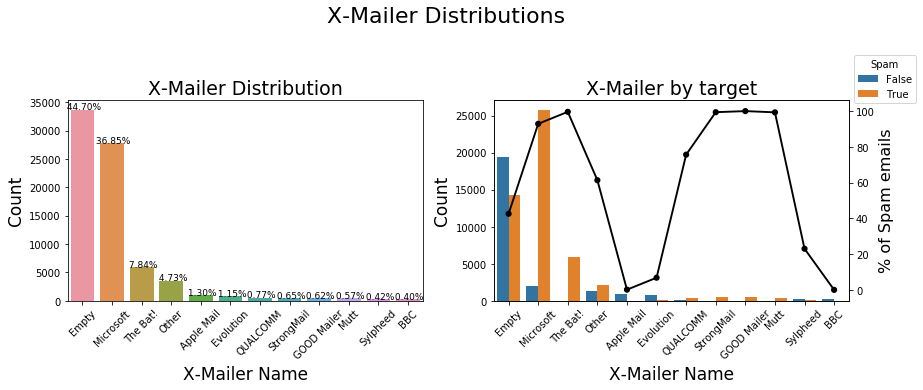

In [211]:
plot_distributions(df, "X-Mailer", xticks_rotation=45)

Много спама для Microsoft Outlook и The Bat!.

#### Status Distribution

In [438]:
df["Status"] = df["Status"].fillna("Empty")
df.loc[~((df["Status"] == "O") | (df["Status"] == "Empty")), "Status"] = "Other"

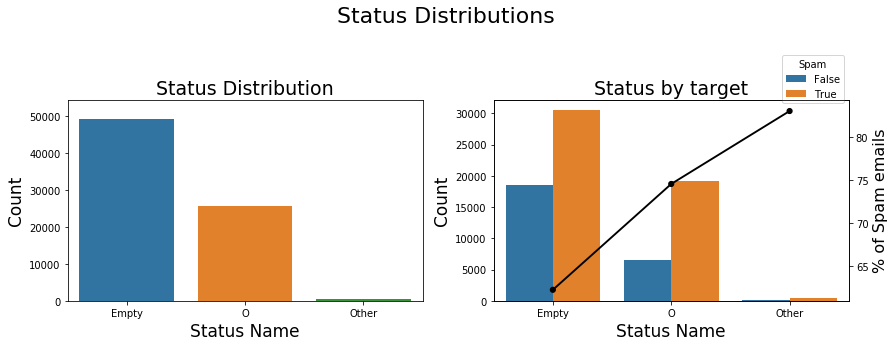

In [439]:
plot_distributions(df, "Status")

#### Date column

In [147]:
datetimes = df[["Date", "target"]].dropna()

In [148]:
def to_dt(x):
    try:
        return pd.to_datetime(x, errors="coerce", exact=False)
    except ValueError:
        return np.nan

In [149]:
datetimes.Date = tmp.Date.map(to_dt)

In [150]:
datetimes.Date.isna().sum()

617

In [151]:
datetimes.Date = pd.to_datetime(datetimes.Date, utc=True)

In [152]:
datetimes

,Date,target
0,2007-04-08 18:00:48+00:00,1
1,2007-04-08 17:19:39+00:00,0
2,2007-04-08 20:08:43+00:00,1
3,2007-04-09 18:31:03+00:00,0
4,2007-04-16 07:56:05+00:00,1
...,...,...
75414,2007-04-16 12:11:00+00:00,1
75415,2007-04-16 02:32:55+00:00,1
75416,2007-04-16 07:53:22+00:00,1
75417,2007-04-16 22:24:23+00:00,1


In [153]:
datetimes = tmp.dropna()

In [154]:
datetimes["year"] = datetimes.Date.dt.year
datetimes["month"] = datetimes.Date.dt.month
datetimes["day"] = datetimes.Date.dt.day
datetimes["weekday"] = datetimes.Date.dt.weekday
datetimes["hour"] = datetimes.Date.dt.hour

In [158]:
datetimes.head()

,Date,target,year,month,day,weekday,hour
0,2007-04-08 18:00:48+00:00,1,2007,4,8,6,18
1,2007-04-08 17:19:39+00:00,0,2007,4,8,6,17
2,2007-04-08 20:08:43+00:00,1,2007,4,8,6,20
3,2007-04-09 18:31:03+00:00,0,2007,4,9,0,18
4,2007-04-16 07:56:05+00:00,1,2007,4,16,0,7


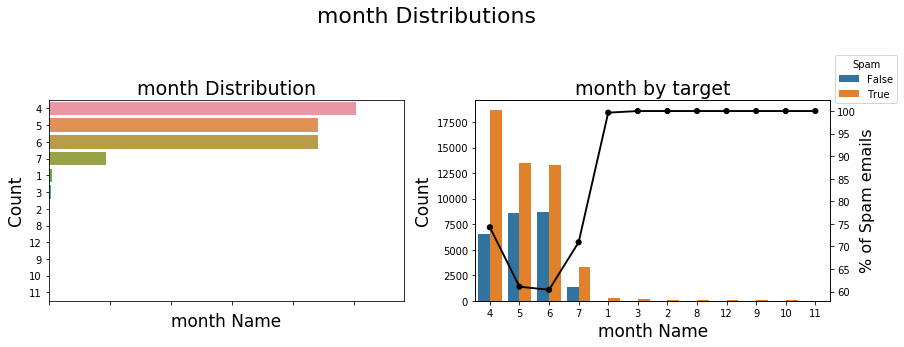

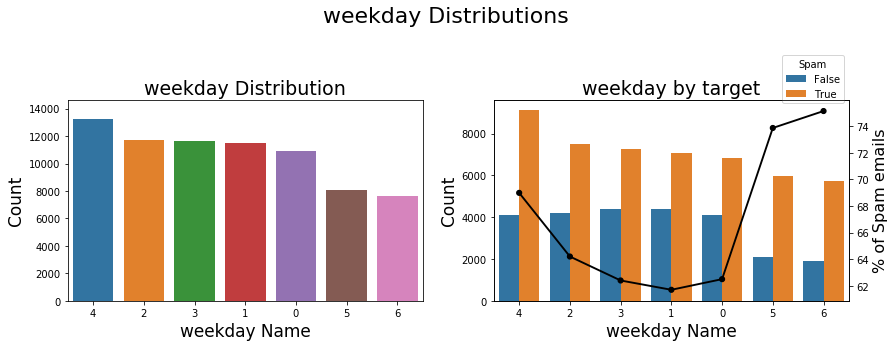

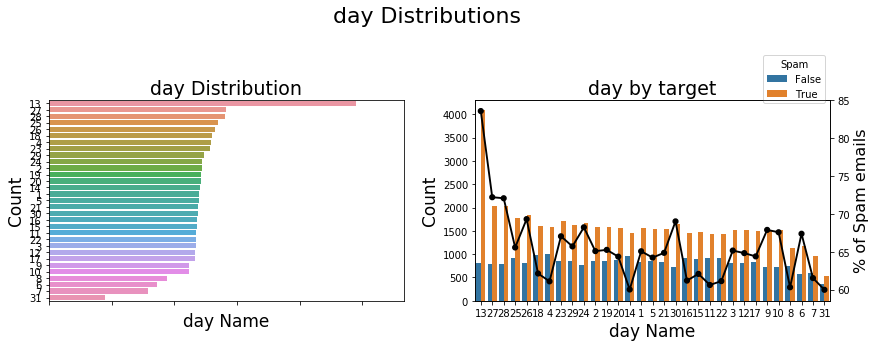

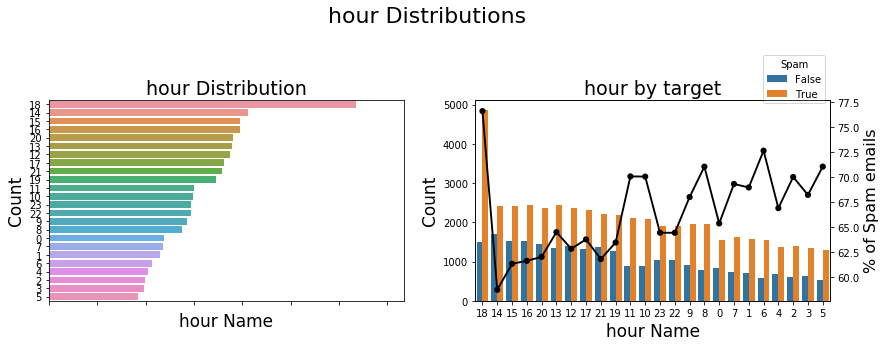

In [391]:
for column in ("month", "weekday", "day", "hour"):
    plot_distributions(datetimes, column)

### Other

In [410]:
print("Empty subject: ", df["Subject"].isna().sum())
print("Empty body: ", df["Body"].isna().sum())
print("Empty subject + body: ", ((df["Subject"].isna()) & (df["Body"].isna())).sum())

Empty subject:  793
Empty body:  2780
Empty subject + body:  72


In [414]:
# 72 is small enough, so let's drop them
print("DataFrame shape before drop: ", df.shape[0])
df.drop(df[(df["Subject"].isna()) & (df["Body"].isna())].index, inplace=True)
print("DataFrame shape after drop: ", df.shape[0])

DataFrame shape before drop:  75419
DataFrame shape after drop:  75347


In [415]:
df["Body"] = df["Body"].fillna("")
df["Subject"] = df["Subject"].fillna("")

In [416]:
X = (df["Subject"] + " " + df["Body"]).to_numpy()

In [417]:
X.shape

(75347,)

**TODO:**
- Domens from urls
- Showing ngrams from `Subject` + `Body`
- Stop-words (nltk, sklearn or other?)
- Modeling 